<B> Synthetic data preparation using gretel.ai</B>
<br>
Link to calls_dataset.csv and domain_knowledge.json: https://drive.google.com/drive/folders/1K7ZD1XkVBtailcLBYIWC2m4nxkbF2r4K?usp=sharing#

Loading required libraries

In [3]:
import re
import nltk
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, multilabel_confusion_matrix

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Data preprocessing

In [4]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

df = pd.read_csv('calls_dataset.csv')
df['cleaned_text'] = df['text_snippet'].apply(preprocess_text)
df.to_csv('cleaned_calls_dataset.csv', index=False)
df.index = range(1, len(df) + 1)

Data Augmentation

In [5]:
df = pd.read_csv('cleaned_calls_dataset.csv')

# Identify minority labels
label_counts = df['labels'].str.split(',').explode().value_counts()
minority_labels = label_counts[label_counts < 10].index.tolist()

# Augment data for minority labels
augmented_data = []
for label in minority_labels:
    subset = df[df['labels'].str.contains(label)]
    augmented_subset = resample(subset, replace=True, n_samples=10, random_state=42)
    augmented_data.append(augmented_subset)

augmented_df = pd.concat(augmented_data)
df = pd.concat([df, augmented_df])
df.to_csv('augmented_calls_dataset.csv', index=False)


Splitting dataset

In [6]:
df = pd.read_csv('augmented_calls_dataset.csv')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

Model training

In [7]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(train_df['cleaned_text'])
X_test = vectorizer.transform(test_df['cleaned_text'])

# Binarize labels
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_df['labels'].str.split(','))
y_test = mlb.transform(test_df['labels'].str.split(','))

# Train model with hyperparameter tuning
param_grid = {'estimator__C': [0.1, 1, 10]}
model = OneVsRestClassifier(LogisticRegression())
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_micro')
grid_search.fit(X_train, y_train)

# Save the trained model, vectorizer, and binarizer
joblib.dump(grid_search, 'multi_label_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(mlb, 'multi_label_binarizer.pkl')

# Evaluate model
y_pred = grid_search.predict(X_test)
report = print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))

                        precision    recall  f1-score   support

           Competition       1.00      0.89      0.94         9
               Feature       1.00      0.62      0.77         8
    Feature Discussion       1.00      1.00      1.00         1
              Features       1.00      1.00      1.00         3
             Objection       0.93      0.81      0.87        16
              Positive       1.00      1.00      1.00         8
    Pricing Discussion       1.00      0.50      0.67         8
 Recommendation Engine       1.00      1.00      1.00         1
           Competition       1.00      1.00      1.00         1
 Competitor Discussion       1.00      1.00      1.00         2
               Feature       1.00      1.00      1.00         2
    Feature Discussion       1.00      0.50      0.67         6
              Negative       1.00      1.00      1.00         5
             Objection       0.78      0.93      0.85        15
              Positive       1.00      

Heatmap of label co-occurrences

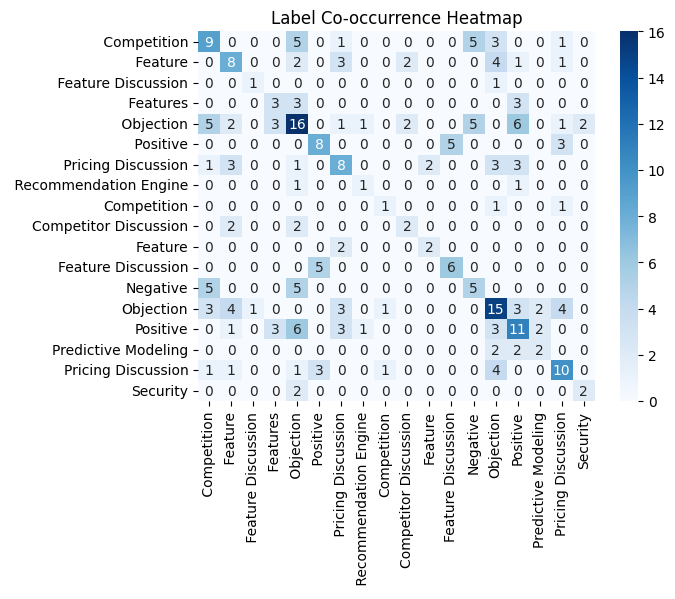

In [8]:
# Load the trained model and vectorizer
model = joblib.load('multi_label_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
mlb = joblib.load('multi_label_binarizer.pkl')

# Save classification report to a CSV file
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('classification_report.csv', index=True)

# Generate confusion matrix
conf_matrix = multilabel_confusion_matrix(y_test, y_pred)

# Plot heatmap of label co-occurrences
label_co_occurrence = pd.DataFrame(y_test.T @ y_test, index=mlb.classes_, columns=mlb.classes_)
sns.heatmap(label_co_occurrence, annot=True, cmap='Blues')
plt.title('Label Co-occurrence Heatmap')
plt.show()

Error Analysis

In [9]:
# Error analysis: Identify misclassifications
misclassified_indices = [i for i in range(len(y_test)) if not (y_test[i] == y_pred[i]).all()]
misclassified_samples = test_df.iloc[misclassified_indices]

# Save misclassified samples to a CSV file
misclassified_samples.to_csv('misclassified_samples.csv', index=False)

# Print examples of misclassifications
print("Examples of Misclassifications:")
for index, row in misclassified_samples.iterrows():
    print(f"Text: {row['text_snippet']}")
    print(f"True Labels: {row['labels']}")
    predicted_labels = mlb.inverse_transform(y_pred[index].reshape(1, -1))[0]
    print(f"Predicted Labels: {', '.join(predicted_labels)}")
    print("----")

Examples of Misclassifications:
Text: Our team has been using CompetitorBb for years, but we're looking for something with better text analytics and a more competitive pricing model. We're considering CompetitorAk and CompetitorAv for our next project.
True Labels: Objection, Pricing Discussion, Competition
Predicted Labels: Objection
----
Text: We've been impressed by the AI capabilities, but we need more information on the setup fee for the long-term contract.
True Labels: Pricing Discussion, Objection
Predicted Labels: Objection
----
Text: Our company is interested in CompetitorCj's computer-aided design capabilities, but we're concerned about the licensing fee. Can you provide a long-term commitment option for our company?
True Labels: Objection, Pricing Discussion, Feature
Predicted Labels: Objection
----
Text: We're evaluating your text analytics capabilities, but we require a free consultation for our organization.
True Labels: Feature Discussion, Positive
Predicted Labels:  Pos

Entity extraction

In [10]:
import json
import re
from collections import defaultdict

# Load domain knowledge base
with open("domain_knowledge.json", "r") as file:
    domain_knowledge = json.load(file)

# Function for dictionary lookup
def dictionary_lookup(text, knowledge_base):
    extracted_entities = defaultdict(list)
    for category, keywords in knowledge_base.items():
        for keyword in keywords:
            if re.search(rf"\b{keyword}\b", text, re.IGNORECASE):
                extracted_entities[category].append(keyword)
    return extracted_entities

# Rule-based NER (regex expansion)
def rule_based_ner(text, knowledge_base):
    rules = {
        "competitors": r"(Competitor[A-Z])",
        "features": r"(" + "|".join(map(re.escape, knowledge_base.get("features", []))) + ")",
        "pricing_keywords": r"(" + "|".join(map(re.escape, knowledge_base.get("pricing_keywords", []))) + ")",
    }
    extracted_entities = defaultdict(list)
    for category, pattern in rules.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        extracted_entities[category].extend(matches)
    return extracted_entities

# Combine dictionary lookup and rule-based NER
def extract_entities(text, knowledge_base):
    # Step 1: Dictionary lookup
    dict_entities = dictionary_lookup(text, knowledge_base)

    # Step 2: Rule-based NER
    rule_entities = rule_based_ner(text, knowledge_base)

    # Combine results
    final_entities = defaultdict(set)
    for category in dict_entities.keys() | rule_entities.keys():
        final_entities[category].update(dict_entities[category])
        final_entities[category].update(rule_entities[category])

    # Convert sets to lists for JSON serialization
    final_entities = {key: list(value) for key, value in final_entities.items()}
    return final_entities

def combined_extraction(text):
    extracted = extract_entities(text, domain_knowledge)
    # Debugging: Print extracted entities for each text
    print(f"Text: {text}\nExtracted Entities: {json.dumps(extracted, indent=4)}\n")
    return extracted

# Debugging: Print domain knowledge
print("Domain Knowledge:", json.dumps(domain_knowledge, indent=4))

Domain Knowledge: {
    "competitors": [
        "CompetitorW",
        "CompetitorV",
        "CompetitorU",
        "CompetitorT",
        "CompetitorS",
        "CompetitorR",
        "CompetitorQ",
        "CompetitorP",
        "CompetitorO",
        "CompetitorN",
        "CompetitorM",
        "CompetitorL",
        "CompetitorK",
        "CompetitorJ",
        "CompetitorI",
        "CompetitorH",
        "CompetitorG",
        "CompetitorF",
        "CompetitorE",
        "CompetitorD",
        "CompetitorC",
        "CompetitorB",
        "CompetitorA",
        "CompetitorX",
        "CompetitorY",
        "CompetitorZ",
        "CompetitorAa",
        "CompetitorAb",
        "CompetitorAc",
        "CompetitorAd",
        "CompetitorAe",
        "CompetitorAf",
        "CompetitorAg",
        "CompetitorAh",
        "CompetitorAi",
        "CompetitorAj",
        "CompetitorAk",
        "CompetitorAl",
        "CompetitorAm",
        "CompetitorAn",
        "CompetitorAo",
 

Entry Extraction for snippets

In [11]:
import pandas as pd

# Load data
df = pd.read_csv('cleaned_calls_dataset.csv')

# Extract entities for each snippet
df['extracted_entities'] = df['cleaned_text'].apply(combined_extraction)
df.index = range(1, len(df) + 1)
# Save the results
df.to_csv('extracted_entities.csv', index=False)

# Print examples
print(df[['cleaned_text', 'extracted_entities']].head())

Text: company using AI customer service, I'm concerned cost implementation. provide information pricing model compare CompetitorAh?
Extracted Entities: {
    "competitors": [
        "CompetitorA",
        "CompetitorAh"
    ],
    "features": [],
    "pricing_keywords": []
}

Text: We've using CompetitorAz years, AI capability limited. I'm interested exploring natural language processing feature.
Extracted Entities: {
    "competitors": [
        "CompetitorA",
        "CompetitorAz"
    ],
    "features": [
        "natural language processing"
    ],
    "pricing_keywords": []
}

Text: I'm interested AI, CompetitorAb offer feature knowledge graph.
Extracted Entities: {
    "competitors": [
        "CompetitorA",
        "CompetitorAb"
    ],
    "features": [
        "knowledge graph"
    ],
    "pricing_keywords": []
}

Text: company looking solution improve customer relationship management, they're concerned long-term commitment setup fee. mentioned CompetitorY flexible pricing pl